
## Mini-projeto de análise exploratória de dados com Python e SQLite


O objetivo deste pequeno projeto é adquirir noções básicas de análises exploratórias de dados consumindo dados de um banco, uma prática fundamental para qualquer cientista de dados. Para isso usei as linguagens Python e SQL e o banco de dados SQLite. Trata-se de um projeto que explora uma base de dados real e pública (IMDB Datasets) sobre produções e filmes para responder algumas perguntas interessantes sobre o assunto:

- 1 - Quais as categorias de produção mais comuns no IMBD?
- 2 - Qual é o número de títulos de filmes por gênero?
- 3 - Qual é a mediana das notas de avaliação por gênero de filme?
- 4 - Qual é a nota média geral dos filmes em relação ao ano de estréia??
- 5 - Qual é o número de filmes estreiando nos principais gêneros ao longo do tempo?
- 6 - Qual o filme com maior tempo de duração e como os filmes estão distribuídos em relação à duração?
- 7 - Qual é a relação entre o gênero e a duração dos filmes?
- 8 - Qual o número de filmes produzidos por país?
- 9 - Quais são os Top10 melhores filmes?
- 10 -Quais são os Top10 piores filmes?

Tá esperando o que para pegar o seu baldinho de pipoca e começar? <br>
<img src="imagens/pernalonga.gif" width="350" height="350" align="left">

-------------------------------------------------------------------------------------------------------------

Vamos iniciar com a configuração do ambiente, instalando e importando os módulos usados no projeto:

In [215]:
# Versão usada no projeto:
from platform import python_version
print(python_version())

3.8.8


In [ ]:
# Instalação
%config IPCompleter.greedy=True
!pip install -q imdb-sqlite # dados no BD SQLite
!pip install -q pycountry #nomes de países a partir dos códigos ISO

In [2]:
# Imports
import re #regEx
import sqlite3 #BD
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer #criação de vetores
import warnings
from IPython.display import Image

In [3]:
# Configs iniciais
warnings.filterwarnings("ignore") #ocultar msg de warning
sns.set_theme(style = "whitegrid") #estilo dos gráficos: bg branco

In [ ]:
# Baixar os dados e transferir para o arquivo do bd
!imdb-sqlite

Feito o dowload dos dados e transferidos para o arquivo .db do SqLite, vamos estabelecer a conexão com o banco e fazer uma consulta para obter o nome de todas as tabelas que há nele:

In [5]:
conexao = sqlite3.connect("imdb.db")
query = "SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'"
tabelas = pd.read_sql_query(query, conexao)
tabelas_lst = list(tabelas["Table_Name"])
print(tabelas_lst)

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']


Agora vamos dar uma inspecionada na estrutura de cada uma das tabelas, para checar os campos e os tipos de dados. Para isso, faremos uma consulta ao catálogo do banco de dados:

In [6]:
for tabela in tabelas_lst:
    query = f"PRAGMA TABLE_INFO({tabela})"
    schema = pd.read_sql_query(query, conexao)
    print(f"Esquema da tabela: {tabela}")
    display(schema)
    print("-"*50, "\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


-------------------------------------------------- 

Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


-------------------------------------------------- 

Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


-------------------------------------------------- 

Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


-------------------------------------------------- 

Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


-------------------------------------------------- 

Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


-------------------------------------------------- 



Agora que possuimos acesso às tabelas e conhecemos melhor sua estrutura, estamos prontos para explorar os dados em busca de potenciais respostas para as nossas perguntas de interesse. #Partiu?

<img src="imagens/tenor.gif" width="200" align="left">


--------------------------------------------------------------------------------------------------------------

### Pergunta 1 - Quais as categorias de produção mais comuns no IMBD?
Podemos responder essa pergunta checando quais categorias possuem mais registros. <br>
As categorias estão representadas pela coluna 'type' da tabela 'titles'. Portanto, vamos agrupar os dados pela categoria e contar quantos registros há em cada uma delas:

In [7]:
query = '''SELECT type, COUNT(*) AS contagem 
            FROM titles 
            GROUP BY type 
            ORDER BY contagem desc'''
resultado1 = pd.read_sql_query(query, conexao)
resultado1.head(5)

,type,contagem
0,tvEpisode,5926850
1,short,821555
2,movie,582788
3,video,314581
4,tvSeries,211043


Apesar desses dados já nos fornecerem uma resposta à nossa pergunta, os dados absolutos pode ser uma forma menos intuitiva de interpretar os dados do que medidas relativas como porcentagens, que nos informam qual é a fração do total representada por cada categoria. Assim, vamos acrescentar uma coluna ao nosso resultado com a % dos diferentes tipos de produção:

In [8]:
total_filmes = resultado1['contagem'].sum()
resultado1['% type'] = round((resultado1['contagem']*100)/total_filmes,2)
resultado1.head()

,type,contagem,% type
0,tvEpisode,5926850,73.18
1,short,821555,10.14
2,movie,582788,7.20
3,video,314581,3.88
4,tvSeries,211043,2.61


In [9]:
# checando soma % categorias = 100
resultado1['% type'].sum()

100.0

Podemos facilitar ainda mais a interpretação dos dados mostrando o resultado em forma de gráfico. Para dar maior ênfase às categorias dominantes, vamos mostrar apenas as três mais comuns e agrupar as demais em uma única categoria geral, que vamos chamar de "Others". 

Porém, para fazer isso primeiro precisamos manipular os dados para consolidar o conjunto de dados adequado, contendo registros desses 2 grandes grupos:

1.others: com a soma dos valores das colunas 'contagem' e '% type' para todas as categorias não dominantes (< 5% dos registros)<br>
2.dominantes: mantendo os valores originais das categorias com % > 5

Vejamos:

In [10]:
# Criando um dicionário com as métricas do grupo others: type, contagem e %
others = {
    "type": "others",
    "contagem": resultado1[resultado1['% type'] < 5]['contagem'].sum(),
    "% type": resultado1[resultado1['% type'] < 5]['% type'].sum()
    }

others

{'type': 'others', 'contagem': 768323, '% type': 9.48}

In [11]:
# Filtrando os dados para obter o subconjunto das mais comuns
resultado1 = resultado1[resultado1['% type'] > 5]

# Juntando os 2 subconjuntos
resultado1 = resultado1.append(others, ignore_index=True)
resultado1

,type,contagem,% type
0,tvEpisode,5926850,73.18
1,short,821555,10.14
2,movie,582788,7.20
3,others,768323,9.48


Agora sim, podemos elabor o gráfico:

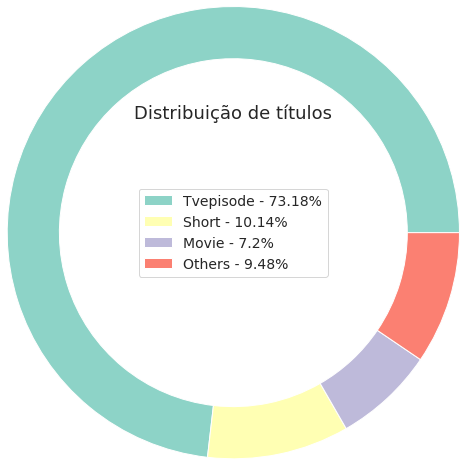

In [13]:
f = plt.figure()
labels = [f"{resultado1.values[i][0].capitalize()} - {resultado1.values[i][2]}%" for i in resultado1.index]
plt.pie(resultado1['contagem'], radius = 2.6, colors = cm.Set3(np.arange(4)), wedgeprops = dict(width = 0.6))
plt.legend(labels = labels, loc = 'center', prop = {'size':14})
plt.title("Distribuição de títulos", loc = 'Center', fontdict = {'fontsize':18,'fontweight':500})
plt.show()

Então, depois de bastante código para elaborar esta análise, vamos voltar a motivação principal que nos levou a fazê-la: responder a pergunta "quais os tipos de produção mais comuns no IMBD?" A partir dos dados, podemos concluir que as categorias mais comuns na IMDB são 'tvEpisode' (em disparada, com mais de 73% dos registros), seguido pela categoria 'short' e 'movie'. Essa pode ser uma informação relevante para tomadores de decisão da área, não?

-------------------------------------------------------------------------------------------------------------

### Pergunta 2- Qual é o número de títulos  de filme por gênero?
Para obter a resposta podemos também trabalhar com valores relativos, apresentando a % de filmes em relação ao total para cada um dos gêneros existentes na lista. Como estamos interessados apenas no tipo de produção "filmes", traremos a consulta filtrada por type = "movies". Vamos lá:

In [14]:
query = "SELECT genres FROM titles WHERE type = 'movie'"
resultado2 = pd.read_sql_query(query, conexao)
display(resultado2.head())

,genres
0,\N
1,"Action,Adventure,Biography"
2,Drama
3,Drama
4,Drama


No retorno da consulta podemos reparar que na coluna 'genres' há filmes enquadrados em mais de um gênero. Para realizar a contagem correta de filmes em cada gênero separadamente esse formato de dados não é interessante.Precisamos de um conjunto de dados onde cada registro de filme (linha) esteja associado a único gênero, ainda que um mesmo filme possa ser atribuído a mais de um gênero (mas em linhas diferentes). Para realizar essa separação em gêneros únicos, iremos manipular os dados e usar a técnica de pré-processamento de textos "one-hot enconding". Você pode pesquisar um pouco mais sobre a técnica nesses 2 links:

1.https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html <br>
2.https://www.educative.io/edpresso/countvectorizer-in-python <br>

In [15]:
# Tratamento para remover valores faltantes e transformar strings em minúsculas
resultado2['genres'] = resultado2['genres'].str.lower().values
generos_temp = resultado2['genres'].dropna()

In [16]:
# Criando lista com registros únicos de gênero
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(generos_temp)
generos_unicos =  vetor.get_feature_names()
generos_unicos[:5]

['action', 'adult', 'adventure', 'animation', 'biography']

In [19]:
# Criar matriz de presença: filmes nas linhas e gêneros nas colunas
# cada filme é assinalado como pertencente (1) ou não (0) a cada um dos gêneros
bag_generos = vetor.transform(generos_temp)
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = generos_temp.index)
generos = generos.drop(columns = 'n', axis = 0) #excluir coluna sem nome
generos.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Agora que temos uma matriz de presença/ausência de filmes vs. gênero, basta fazer o somatório das colunas para obter o total de filmes de cada gênero. Com esse dado, também conseguiremos obter a % de filmes por gênero:

In [20]:
total_filmes = generos.shape[0]  #n linhas
total_filmes_genero = generos.sum().sort_values(ascending = False) #soma e ordenação da contagem
generos_percent = round((total_filmes_genero*100)/total_filmes,2)
generos_percent.head()

drama          35.99
documentary    18.34
comedy         17.08
action          8.55
romance         7.49
dtype: float64

Agora sim, com o conjunto de dados correto, podemos elaborar o gráfico e responder nossa pergunta sobre como é a distribuição de filmes por gênero. Lembrando apenas que nesse caso - diferente do anterior - um mesmo filme pode ter sido classificado em mais de um gênero:

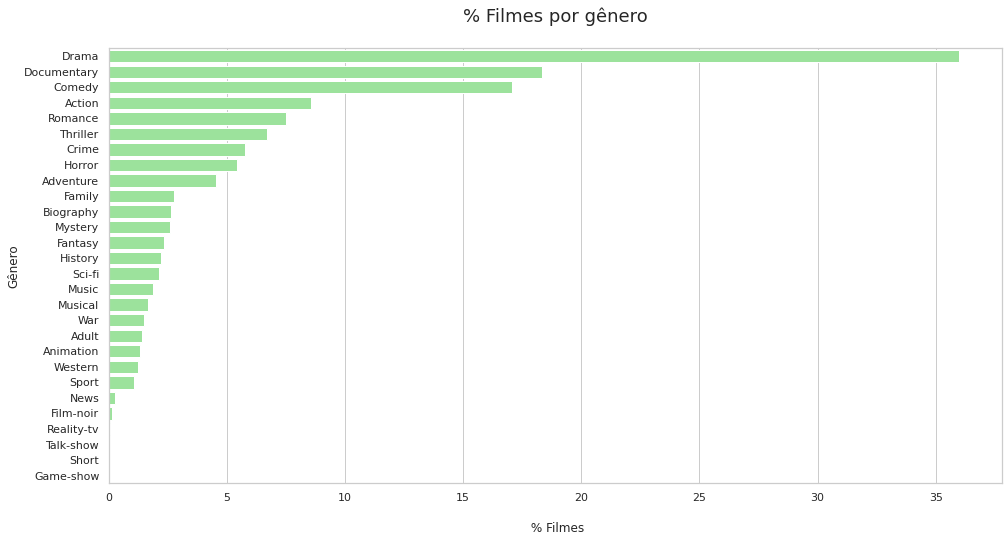

In [22]:
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percent.values, 
            y = [gen.capitalize() for gen in generos_percent.index], 
            orient = "h", 
            color="lightgreen")
plt.ylabel('Gênero')             
plt.xlabel("\n % Filmes")
plt.title('% Filmes por gênero\n', fontdict = {'fontsize':18,'fontweight':500})
plt.show()

O gênero com maior número de filmes é drama (36%), com o dobro de filmes do gênero documentário (~18%),que vem em 2° lugar. Enquanto que filmes dos gêneros game-show são os menos frequentes (<0.001%). 

E você, qual é o seu gênero preferido de filme?

-------------------------------------------------------------------------------------------------------------

### Pergunta 3 - Qual é a mediana das notas de avaliação por gênero de filme?

É importante aqui justificarmos porque usamos a mediana, ao invés da média. A média é uma medida de tendência central muito influenciada por valores extremos (outliers) e ainda não fizemos nenhuma investigação mais apurada dos dados. Portanto, não sabemos se há outliers. A mediana também é uma medida de tendência central como a média, porém, menos influenciada por esses valores discrepante, e representa o valor que divide o conjunto de dados ao meio. Ou seja, 50% dos meus valores são menores do que a mediana, e 50% são maiores que ela.

Primeiro, vejamos como estão estruturadas os dados das notas de avaliações no banco de dados (tabela ratings):

In [23]:
query = "SELECT * FROM ratings LIMIT 5"
resultado3 = pd.read_sql_query(query,conexao)
resultado3.head()

,title_id,rating,votes
0,tt0000001,5.7,1725
1,tt0000002,6.0,211
2,tt0000003,6.5,1487
3,tt0000004,6.1,125
4,tt0000005,6.2,2288


Estamos interessados nas notas por gênero. Porém, não temos nenhuma coluna que nos informa o gênero do filme avaliado nesta mesma tabela de notas. Precisamos buscar esses dados em outra tabela. Mas repare que a tabela tem a coluna title_id e que esse mesmo campo está presente na tabela 'titles', como mostrado abaixo:

In [24]:
query = "SELECT * FROM titles LIMIT 5"
resultado3 = pd.read_sql_query(query,conexao)
resultado3.head(1)

,title_id,type,primary_title,original_title,is_adult,premiered,ended,runtime_minutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"


Essa última tabela traz também o gênero, além do title_id. Portanto, faremos um 'join' entre as duas tabelas (ratings e titles) para mesclar os dados de nota de avaliação e gênero dos títutos, usando o campo title_id como chave, já que ele é comum entre elas:

In [25]:
query = '''
        SELECT rating, genres FROM
        ratings JOIN titles ON ratings.title_id = titles.title_id
        WHERE premiered <= 2022 and type = 'movie'
        '''
resultado3 = pd.read_sql_query(query,conexao)
resultado3.head()

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama


Repare que temos o mesmo problema da pergunta anterior: alguns títulos estão enquadrados em mais de um gênero. E precisaremos implementar a mesma lógica de desagrupar os gêneros para obter notas por gêneros únicos. Como iremos utilizar essa lógica mais vezes a partir daqui, vamos encapsulá-la em uma função para garantir o reaproveitamento e o uso desse trecho de código:

In [26]:
def retornar_generos_unicos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [27]:
generos_unicos = retornar_generos_unicos(resultado3)
print(generos_unicos)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


Com essa lista de gêneros únicos, realizaremos uma consulta que retorna os valores das notas (para o cálculo da mediana) e o número de registros de notas (dados utilizados no futuro gráfico) para cada um desses gêneros:

In [28]:
# query para contagem de notas por gênero
contagem_notas_genero = []
for genero in generos_unicos:
    query = f"SELECT COUNT(rating) from ratings JOIN titles \
    ON ratings.title_id = titles.title_id \
    WHERE genres LIKE \'%{genero}%\' AND type=\'movie\'"
    
    resultado = pd.read_sql_query(query , conexao)
    contagem_notas_genero.append(resultado.values[0][0])
print(contagem_notas_genero[:5])

[28540, 4078, 17545, 4624, 7977]


In [29]:
# query para valores de notas por gênero
mediana_notas_genero = []
for genero in generos_unicos:
    query = f"SELECT rating, genres from ratings JOIN titles \
    ON ratings.title_id = titles.title_id \
    WHERE genres LIKE \'%{genero}%\' AND type=\'movie\'"
    
    resultado = pd.read_sql_query(query , conexao)
    mediana_notas_genero.append(np.median(resultado['rating']))
print(mediana_notas_genero[:5])
    

[5.8, 5.8, 6.0, 6.4, 7.0]


Agora vamos reunir as duas listas em um conjunto de dados único e elaborar o gráfico:

In [30]:
df_notas_genero = pd.DataFrame()
df_notas_genero['genres'] = generos_unicos
df_notas_genero['count'] = contagem_notas_genero
df_notas_genero['ratings']= mediana_notas_genero
df_notas_genero = df_notas_genero.sort_values(by="ratings", ascending=False)
df_notas_genero.head(1)

,genres,count,ratings
18,news,658,7.3


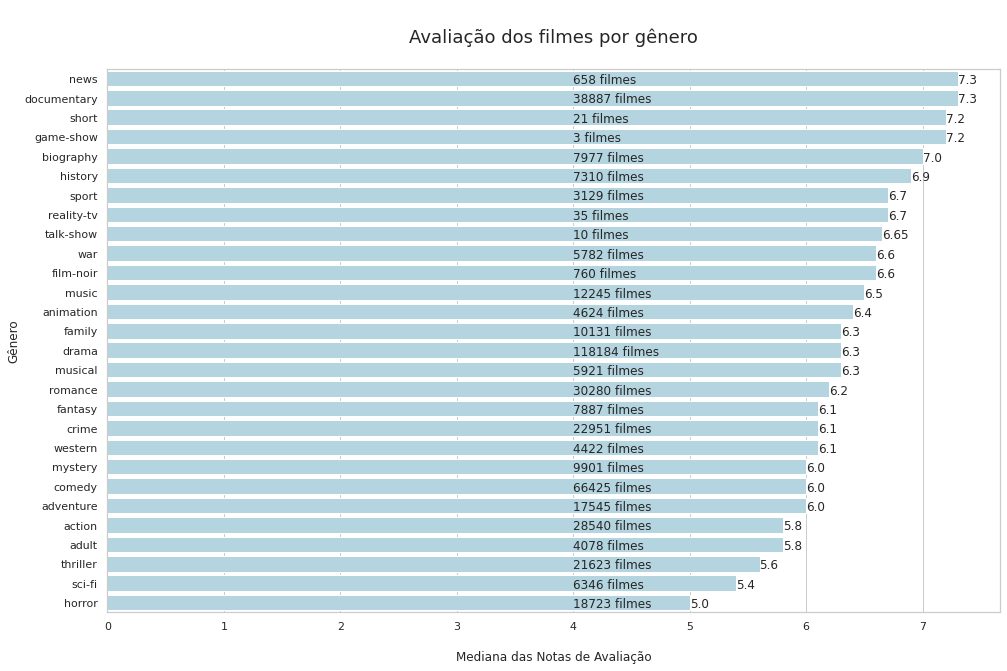

In [33]:
# Gráfico
plt.figure(figsize = (16,10))
sns.barplot(y=df_notas_genero['genres'], x=df_notas_genero['ratings'], color='lightblue')
plt.ylabel('Gênero')             
plt.xlabel('\nMediana das Notas de Avaliação')
plt.title('\nAvaliação dos filmes por gênero\n',fontdict = {'fontsize':18,'fontweight':500})

# Textos
for i in range(len(df_notas_genero.index)):
    plt.text(4,i + 0.25, 
             f"{df_notas_genero['count'][df_notas_genero.index[i]]} filmes")
    plt.text(df_notas_genero['ratings'][df_notas_genero.index[i]], i+0.25, 
             round(df_notas_genero['ratings'][df_notas_genero.index[i]],2))           
plt.show()


Conclusão da pergunta 3: podemos ver que os gêneros de filmes com maior nota de avaliação (mediana) é 'news' e 'documentary'. Em seguida temos 'short' e 'game-show', mas perceba que o número de avaliações para esses gêneros é muito menor que os demais (21 e 3, respectivamente). Talvez futuramente valha a pena refazer as análises filtrando os gêneros que tem um número mínimo de avaliações (por exemplo, 1000). Mas por enquanto vamos ficar com esse resultado exploratório que já traz alguns insights interessantes!

---------------------------------------------------------------------------------------------------------------

### Testando uma outra forma de obter a resposta para a pergunta 3

Apenas para fins de aprendizagem, podemos manipular os dados de uma outra forma. Ao invés de realizar o laço para fazer uma consulta para cada gênero ao banco de dados, também seria possível realizar uma única consulta para trazer todos os dados e manipular o conjunto de dados (dataframe) localmente:

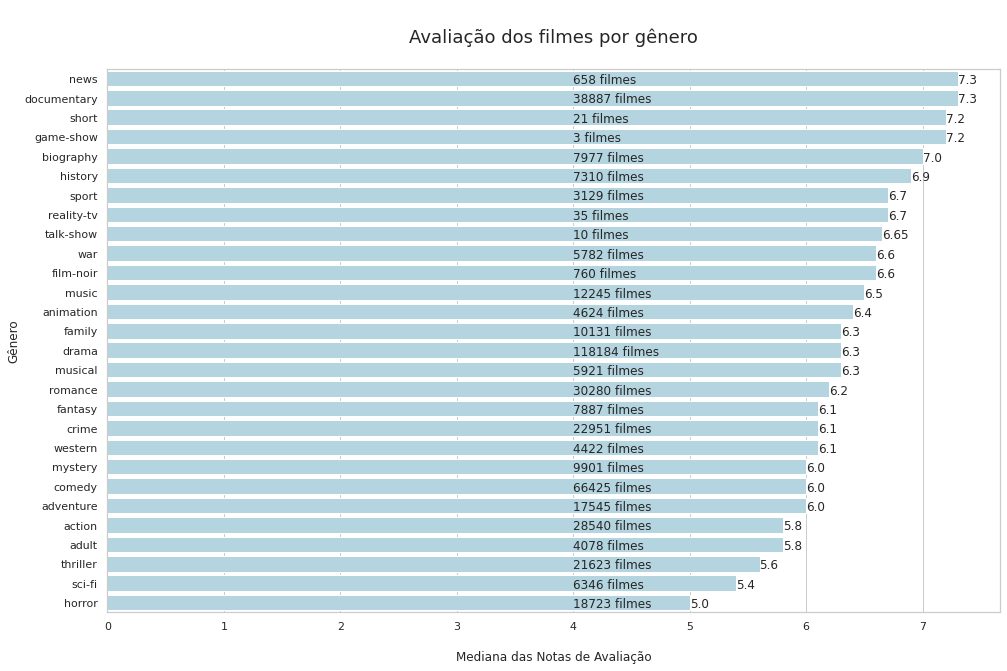

In [34]:
# consulta com notas e genero
query = "SELECT genres AS genero, rating AS nota  \
         FROM titles JOIN ratings ON titles.title_id = ratings.title_id \
         WHERE titles.type ='movie'"
r = pd.read_sql_query(query, conexao)
r['genero'] = r['genero'].str.lower().values


# usando a lista de gêneros únicos para filtrar notas de avaliação por genero e calcular mediana: 
df = pd.DataFrame()
for genero in generos_unicos:
    notas_genero_lst = [nota_r for (genero_r,nota_r) in zip(r['genero'], r['nota']) if genero in genero_r]
    df = df.append({
                    "genero": genero, 
                    "contagem": len(notas_genero_lst), 
                    "nota_md": np.median(notas_genero_lst)
                   },ignore_index=True)

df = df.sort_values(by="nota_md", ascending=False)    
df.head()


# Gráfico
plt.figure(figsize = (16,10))
sns.barplot(y=df['genero'], x=df['nota_md'], color='lightblue')
plt.ylabel('Gênero')             
plt.xlabel('\nMediana das Notas de Avaliação')
plt.title('\nAvaliação dos filmes por gênero\n', fontdict = {'fontsize':18,'fontweight':500})

# Textos
for i in range(len(df.index)):
    plt.text(4,i + 0.25, 
             f"{round(df['contagem'][df.index[i]])} filmes")
    plt.text(df['nota_md'][df.index[i]], i+0.25, 
             round(df['nota_md'][df.index[i]],2))           
plt.show()


______________________________________________________________________________________________________________

### Pergunta 4 - Qual é a nota média geral dos filmes em relação ao ano de estréia?

Será que filmes mais antigos tem menor nota de avaliação?Ou o contrário, filmes mais antigos foram mais bem avaliados pelos expectadores?Para responder essa pergunta, vamos fazer um gráfico plotando a média das notas em função do ano de estréia. Aqui (e nas próximas perguntas) vamos quebrar a regra anterior e trabalhar com a média ao invés da mediana apenas para fins de exploração e aprendizado de uma nova métrica descritiva. Mas, em uma próxima análise, será melhor investigar o comportamento dos outliers antes de tomar essa decisão! #ficadica

In [35]:
query = '''
        SELECT rating as avaliacao,premiered as estreia \
        FROM ratings JOIN titles ON ratings.title_id = titles.title_id \
        WHERE premiered <= 2022 AND type='movie'
        ORDER BY premiered
        '''
resultado4 = pd.read_sql_query(query,conexao)
display(resultado4.head())

,avaliacao,estreia
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900


In [36]:
anos = set(resultado4['estreia']) #conjunto dos anos: valores únicos

Conhecendo agora os anos registrados no conjunto de dados, vamos realizar uma iteração sobre eles, filtrando as notas para cada um dos anos e calculando a média delas:

In [37]:
notas = []
for ano in anos:
    notas_temp = np.mean(resultado4[resultado4['estreia'] == ano]['avaliacao'])
    notas.append(notas_temp)  

E agora sim, plotar o gráfico:

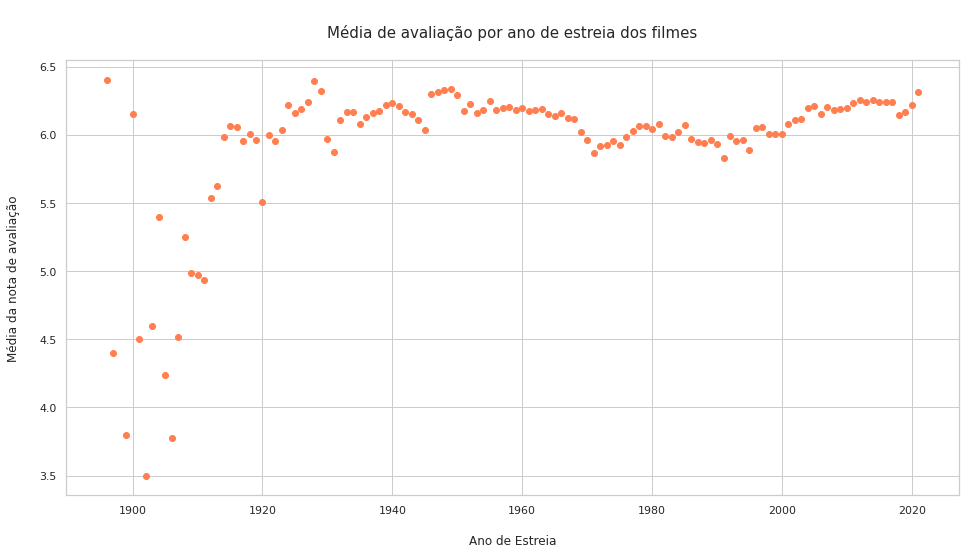

In [52]:
plt.figure(figsize = (16,8))
plt.plot(list(anos),notas, 'o', color='coral')
plt.xlabel('\nAno de Estreia')
plt.ylabel('Média da nota de avaliação\n')
plt.title('\nMédia de avaliação por ano de estreia dos filmes\n',
          fontdict = {'fontsize':15,'fontweight':500})
plt.show()

Pela figura percebemos que existe uma grande variação na nota média de avaliação dos filmes mais antigos de um ano para outro. E que filmes com data de estréia mais recente foram melhores avaliados. Poderíamos propor algumas hipóteses para explicar esse resultado mas, por ora, deixaremos como está, já que não é o foco do nosso problema de negócio!


------------------------------------------------------------------------------------------------------------------


### Pergunta 5 - Qual é o número de filmes estreiando nos principais gêneros ao longo do tempo?

Para responder essa pergunta faremos um gráfico de linha com o número de títulos que estreiaram a cada ano, mas com dados segregados por gênero. Para refinar um pouco nossa análise e melhorar a visualização, trabalharemos apenas com os gêneros principais. Ou seja, aqueles 5 gêneros com maior número de títulos. 

Portanto, a primeira parte da análise será focada em obter quais são esses 5 principais gêneros:

In [39]:
# Obter coluna de gêneros do banco de dados
query = "SELECT genres FROM titles"
resultado5 = pd.read_sql_query(query, conexao)
display(resultado5.head())

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"


In [40]:
# Manipulação para obter gêneros únicos
generos_unicos = retornar_generos_unicos(resultado5)

In [41]:
# Obter contagem de títulos por gênero
generos_contagem = []
for genero in generos_unicos:
    query = f"SELECT COUNT(*) AS contagem \
    FROM titles \
    WHERE genres like \'%{genero}%\' AND type=\'movie\' AND premiered <=2022"
    
    resultado = pd.read_sql_query(query, conexao)
    generos_contagem.append(resultado['contagem'].values[0])
print(generos_contagem)

[41242, 8168, 22538, 6438, 13105, 88670, 30011, 100623, 185884, 14400, 10983, 761, 14, 11523, 23994, 19189, 9056, 13146, 1383, 399, 40557, 8219, 51, 5550, 124, 28521, 8010, 6614]


In [42]:
# Construindo dataframe unindo dados de gênero e contagem :
df_genero_contagem = pd.DataFrame()
df_genero_contagem['genre'] = generos_unicos
df_genero_contagem['count'] = generos_contagem
df_genero_contagem.head()

,genre,count
0,action,41242
1,adult,8168
2,adventure,22538
3,animation,6438
4,biography,13105


Agora que já temos os dados de contagem para todos os gênero, podemos ordenar os dados de forma decrescente para obter os 5 gêneros com maior número de registros:

In [43]:
top_generos = df_genero_contagem.sort_values(by='count', ascending=False).head(5)
top_generos

,genre,count
8,drama,185884
7,documentary,100623
5,comedy,88670
0,action,41242
20,romance,40557


A próxima etapa é realizar uma consulta trazendo a contagem de títulos agrupada por ano de estreia para cada um dos gêneros principais. E já podemos usar o retorno da consulta para plotar a série de cada gênero em um mesmo gráfico:

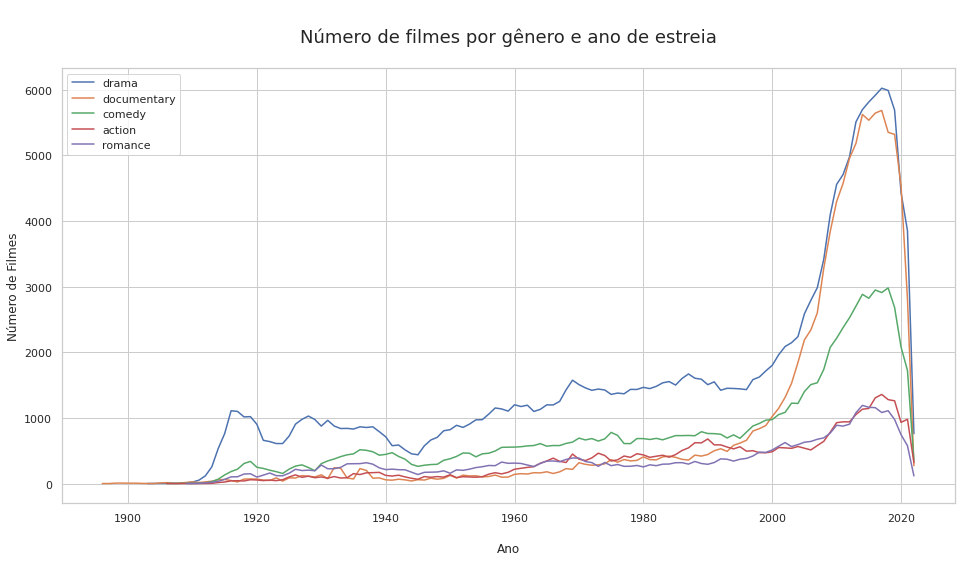

In [44]:
plt.figure(figsize = (16,8))

# Populando o gráfico com as consultas de número de avaliações por ano para cada gênero:
for gen in top_generos['genre']:
    query = f"SELECT COUNT(*) AS contagem, premiered AS ano \
    FROM titles WHERE genres LIKE \'%{gen}%\' AND type=\'movie\' AND ano <=2022 \
    GROUP BY ano"
    resultado = pd.read_sql_query(query, conexao)
    plt.plot(resultado['ano'], resultado['contagem'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes')
plt.title('\nNúmero de filmes por gênero e ano de estreia\n', fontdict = {'fontsize':18,'fontweight':500})
plt.legend(labels = top_generos['genre'])
plt.show()
    

Observando o nosso resultado vemos que existe uma tendência clara de aumento do número de filmes estreiando ao longo do tempo, sobretudo a partir dos anos 2000. Quais hipóteses você sugeriria para explicar esse resultado?E quais análises você faria para investigar sua hipótese?Vale o exercício de refletir e - quem sabe - implementar futuramente!

-------------------------------------------------------------------------------------------------------------

### Pergunta 6 - Qual o filme com maior tempo de duração?Mostre como os filmes estão distribuídos em relação ao tempo de duração.

Para checar que filme tem maior duração podemos fazer uma consulta ordenada de forma decrescente do campo que mostra a duração. O filme mais longo será o primeiro da lista:

In [45]:
query = "SELECT runtime_minutes as runtime, primary_title as title, original_title as subtitle \
         FROM titles WHERE type = 'movie' AND runtime != 'NaN' \
         ORDER BY runtime DESC \
         LIMIT 1"
resultado6 = pd.read_sql_query(query,conexao)
display(resultado6)

,runtime,title,subtitle
0,51420,Logistics,Logistics


O filme com maior duração registrado na plataforma é o "Logistics", com 51420 minutos de duração. Isso equivale a mais de 857 horas de filme!E não, isto não é um erro. O filme realmente existe e tem esta duração, sendo considerado o filme mais longo da história (https://en.wikipedia.org/wiki/Logistics_(film)). Haja fôlego pra maratonar esse título hein?

Vamos agora checar a distribuição dos valores de duração dos filmes usando quartis (Q1, Q2 e Q3). Os quartis são os valores que dividem o conjunto de dados em 4 partes iguais, com cada uma delas contendo 25% dos valores da distribuição. O segundo quartil (Q2) é também a mediana, o valor que divide a distribuição de valores ao meio. Ou seja, 50% dos valores do conjunto de dados são menores que esse valor e 50% são maiores. Vejamos quais são os quartis dessa distribuição:

In [46]:
query = "SELECT runtime_minutes as runtime \
         FROM titles WHERE type = 'movie' AND runtime != 'NaN'"

resultado6 = pd.read_sql_query(query,conexao)

#calculando os quartis
quartis = [25,50,75]
for index,q in enumerate(quartis):
    valor = round(np.percentile(resultado6['runtime'].values,q),2)
    print(f" Quartil {index+1}: {valor}")

 Quartil 1: 74.0
 Quartil 2: 89.0
 Quartil 3: 100.0


Temos então que a mediana (Q2) vale 89 minutos. Ou seja, metade dos filmes duram menos que esse tempo. Enquanto que 25% dos filmes duram menos que 74 minutos (Q1). Já entre os filmes mais longos, apenas 25% duram mais que 100 minutos (Q3).

______________________________________________________________________________________________________________

### Pergunta 7 - Qual é a relação entre o gênero e a duração dos filmes?

Para esta pergunta, iremos resumir a duração dos filme em uma medida de tendência, a média. Portanto, iremos investigar qual é a relação da duração média dos filmes com o gênero. Quais os gêneros de filme com maior duração média?E filmes de quais gêneros duram menos, em média?Vamos investigar!

Lembrando que, como estamos trabalhando mais uma vez com os gêneros, precisaremos usar nossa função que retorna os gêneros únicos (célula 96). E, a partir daí, calcular a duração média para cada um deles.

In [47]:
# obtendo dados de duração e gênero
query = "SELECT genres, runtime_minutes FROM titles \
         WHERE type = 'movie' AND runtime_minutes != 'NaN'"
resultado7 = pd.read_sql_query(query,conexao)
resultado7.head()

,genres,runtime_minutes
0,\N,100
1,"Action,Adventure,Biography",70
2,Drama,90
3,"Adventure,Fantasy",120
4,"Adventure,Drama",58


In [48]:
# obtendo gêneros únicos:
generos_unicos = retornar_generos_unicos(resultado7)
generos_unicos[:6]

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy']

Vamos agora percorrer a lista de gêneros únicos e consultar os dados de duração para cada um deles no banco. E, a partir daí, já calcular a média desses dados filtrados. Vamos também ter cuidado para fazer a consulta desconsiderando títulos de filmes que não possuem registros de duração (runtime = NaN):

In [49]:
duracao_generos = []
for genero in generos_unicos:
    query = f"SELECT runtime_minutes AS runtime \
                FROM titles \
                WHERE genres LIKE '%{genero}%' AND type = 'movie' AND runtime != 'NaN'"
    resultado_temp = pd.read_sql_query(query, conexao)
    duracao_generos.append(np.mean(resultado_temp['runtime'])) #media por gênero
    
print(duracao_generos[:6])

[99.51435931685909, 77.8566943674977, 92.44937032865772, 82.23054545454545, 88.36560447579664, 92.60741436069648]


Já que temos a lista de gêneros únicos e a média para cada um deles, vamos preparar o conjunto de dados usados no gráfico concatenando essas 2 listas em um mesmo dataframe:

In [50]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = duracao_generos
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)
display(df_genero_runtime[:6])

,genre,runtime
0,action,99.514359
16,musical,98.580867
20,romance,97.780915
8,drama,96.441670
26,war,95.599793
25,thriller,95.557818


E agora sim elaborar o gráfico para extrair as respostas que estamos buscando:

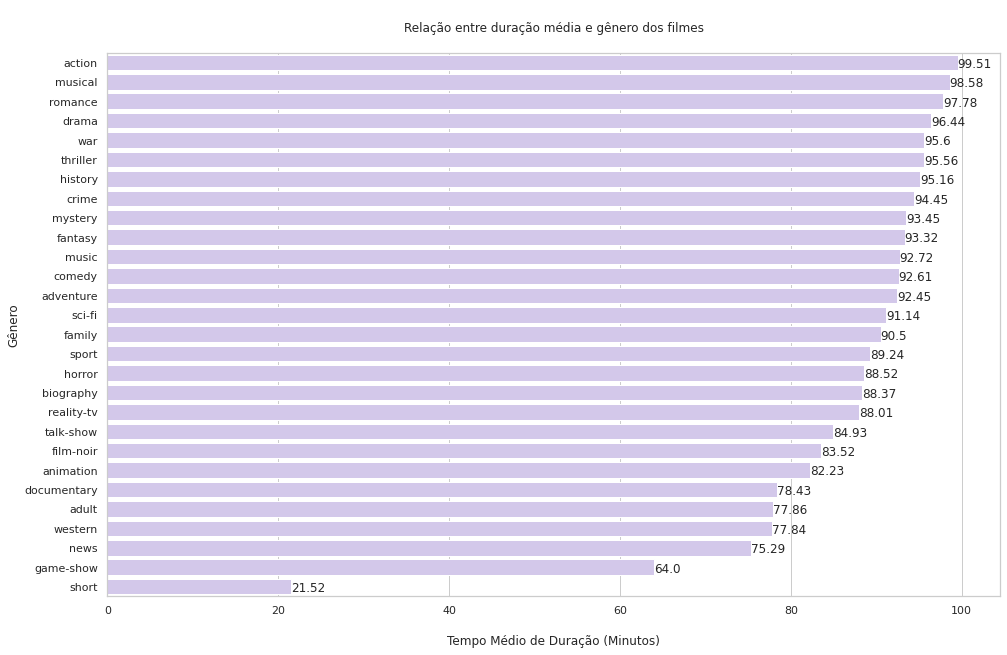

In [51]:
# Gráfico
plt.figure(figsize = (16,10))
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient='h', color='#D1C2F0')

# Loop para anotar a média
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nTempo Médio de Duração (Minutos)')
plt.title('\nRelação entre duração média e gênero dos filmes\n')
plt.show()


De acordo com o nosso resultado vemos que os gêneros de filme com maior duração média é ação (99'), musical (98') e romance (97'). E os de menor duração, claro, são os do gênero 'short' (21'). Nesse ponto não temos nenhuma surpresa, nao é  mesmo?

-----------------------------------------------------------------------------------------------

### Pergunta 8 - Qual o número de filmes produzidos por país?

Precisamos fazer a contagem de títulos de filmes produzidos por país. Na tabela onde está o país de origem também há um campo title_id, que permitiria fazer a contagem agrupada por país usando apenas essa tabela. Porém, como estamos trabalhando apenas com a categoria filmes (type = 'movie') e esse campo está em outra tabela, mais uma vez vamos fazer o JOIN para trazer dados de esquemas diferentes:

In [290]:
query = "SELECT COUNT(*) as count, region \
         FROM akas JOIN titles ON akas.title_id = titles.title_id \
         WHERE akas.region != 'None' AND titles.type = 'movie' \
         GROUP BY region"

resultado8 = pd.read_sql_query(query,conexao)
display(resultado8.head())

,count,region
0,22,AD
1,318,AE
2,108,AF
3,12,AG
4,1229,AL


Perceba que na coluna 'region' temos a sigla dos países que produziram os filmes, ao invés do nome por extenso. O resultado apresentado desta forma pode gerar alguma dificuldade de interpretação para quem não está tão familiarizado com os dados, como por exemplo, gestores e tomadores de decisçao. Portanto, vamos usar uma biblioteca para retornar o nome do país a partir da sigla:

In [291]:
nomes_paises = []
contagem = []

for i in range(resultado8.shape[0]):
    try:
        pais_sigla = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = pais_sigla).name)
        contagem.append(resultado8['count'].values[i])
    except:
        continue

Usamos o bloco TRY/EXCEPT com a cláusula "continue" para não interromper o código caso haja alguma exceção, como uma sigla de país para a qual não existe nome correspondente.

Vamos agora reunir os dados de contagem e nome de países em um mesmo dataframe:

In [294]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['count'] = contagem
df_filmes_paises = df_filmes_paises.sort_values(by = 'count', ascending = False)
display(df_filmes_paises.head())

,country,count
198,United States,258160
65,United Kingdom,114649
96,Japan,87929
63,France,81178
89,India,71334


E agora sim podemos plotar o gráfico. Porém, para isso usaremos apenas os 10 países com maior número de produções para não poluir tanto a nossa visualização e facilitar a nossa interpretação. Ou seja, vamos apresentar um TOP10 de países produtores de filmes:

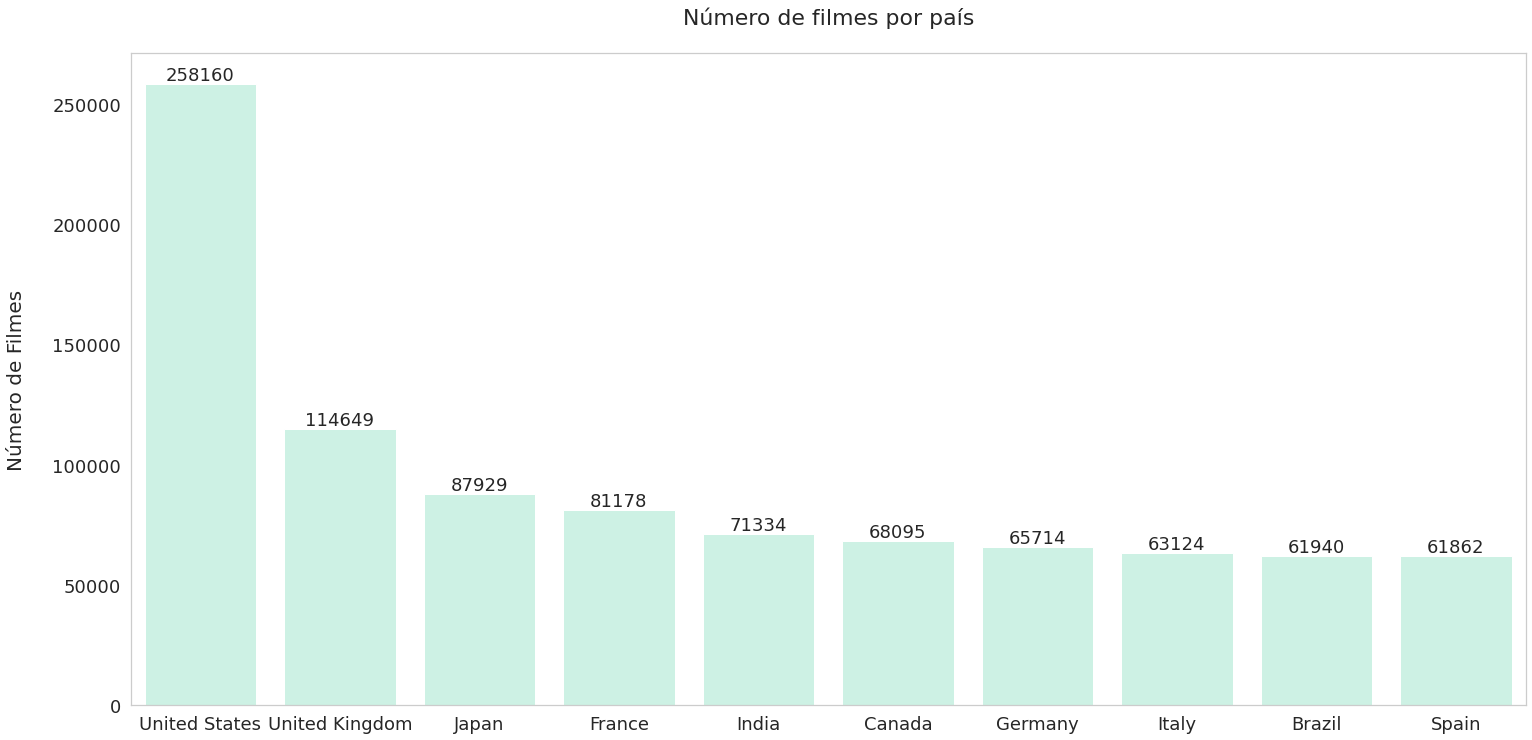

In [309]:
plt.figure(figsize = (25,12))

sns.set_style("whitegrid", {'axes.grid' : False})
b = sns.barplot(x = df_filmes_paises[:10]['country'], y = df_filmes_paises[:10]['count'],color="#C7F7E5")
b.axes.set_title("Número de filmes por país\n",fontsize=22)
b.set_xlabel("",fontsize=20)
b.set_ylabel("Número de Filmes\n",fontsize=20)
b.tick_params(labelsize=18)

for p in b.patches:
    b.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   size = '18', ha = 'center', va = 'center', 
                   xytext = (0, 9), textcoords = 'offset points')

plt.show()

Vemos pelo nosso gráfico que os Estados Unidos é - de longe - o maior produtor de filmes no mundo (segundo a fonte que consultamos) com mais que o dobro do 2° colocado, o Reino Unido. É interessante notar também que o Brasil figura no TOP10 maiores produtores, ocupando a 9ª colocação.

______________________________________________________________________________________________________________

### Pergunta 9 e 10 - Quais são os TOP10 melhores e piores filmes?

Para responder essa pergunta, faz sentido buscar filmes que tiveram uma quantidade mínima de avaliações, para que nosso resultado não seja muito influenciado por filmes com poucas notas e/ou com valores discrepantes. Para isso, vamos usar o número de corte de 25mil avaliações. Vamos lá então em busca no nosso TOP10. Primeiro, buscando os melhores filmes:

In [310]:
query = "SELECT primary_title AS movie, genres, rating \
         FROM titles JOIN ratings ON  titles.title_id = ratings.title_id \
         WHERE titles.type = 'movie' AND ratings.votes >= 25000 \
         ORDER BY rating DESC \
         LIMIT 10"

top10_melhores_filmes = pd.read_sql_query(query, conexao)
display(top10_melhores_filmes)

,movie,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


E agora os piores:

In [311]:
query = "SELECT primary_title AS movie, genres, rating \
         FROM titles JOIN ratings ON  titles.title_id = ratings.title_id \
         WHERE titles.type = 'movie' AND ratings.votes >= 25000 \
         ORDER BY rating \
         LIMIT 10"

top10_piores_filmes = pd.read_sql_query(query, conexao)
display(top10_piores_filmes)

,movie,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: the Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9


E aí, concorda com essa lista?Já assistiu alguns desses filmes?Seu filme preferido ficou de fora?Bom...o meu também. Mas também pode ser uma boa oportunidade para descobrir novos filmes.


Tá esperando o que pra começar a maratona?

<img src="imagens\frog.jpg" width="450" height="500" align="center">

-------------------------------------------------------------------------------------------------------------
### Referências:

1. Curso Python Fundamentos Para Análise de Dados (Data Science Academy): https://www.datascienceacademy.com.br/course/python-fundamentos

2. IMDb Datasets: https://www.imdb.com/interfaces/

3. Documentação Scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

4. Artigo sobre one-hot enconding: https://www.educative.io/edpresso/countvectorizer-in-python

5. Fonte da imagem do sapo: https://pixabay.com/pt/photos/sapo-cinema-pipoca-engra%c3%a7ado-1672887/
6. Fonte dos gifs: https://giphy.com/